In [8]:
from sdRDM import DataModel
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import numpy as np

In [9]:
params = dict(K_m=17, k_cat=12, k_ie=0.1, K_ic=10)


enzyme_conc = 1
init_substrates = np.linspace(10, 60, 3)
init_enzymes = np.repeat(enzyme_conc, 3)
init_product = np.zeros(3)

w0s = np.append(init_substrates, init_enzymes).reshape(2, 3)
w0s = np.append(w0s, init_product).reshape(3, 3).T
time = np.linspace(0, 10, 20)


def model(w0, t, params):
    s, e, p = w0
    ds = -s * e * params["k_cat"] / \
        (params["K_m"] * (1 + (p / params["K_ic"])) + s)
    de = -params["k_ie"] * e

    return [ds, de, -ds]


def simulate(w0s, t, **params):
    return np.array([odeint(model, w0, t, args=(params,)) for w0 in w0s])


sim_substrate = simulate(w0s, time, **params)[:, :, 0]

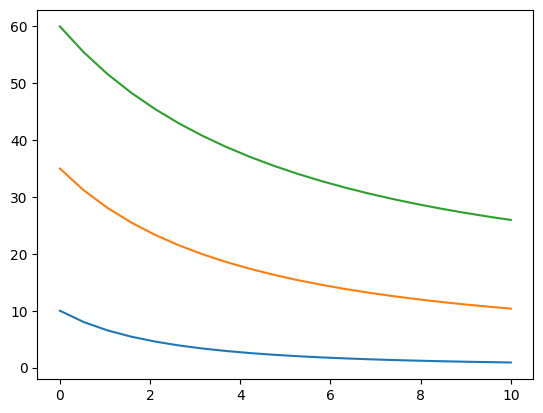

In [10]:
for substrate in sim_substrate:
    plt.plot(time, substrate)

In [11]:
pe = DataModel.from_git(
    "https://github.com/EnzymeML/enzymeml-specifications.git")

In [12]:
unit = "mmol / l"

In [13]:
doc = pe.EnzymeMLDocument(name="simulated data")

vessel = doc.add_to_vessels(name="vessel", volume=1, unit="litre")

substrate = doc.add_to_reactants(
    name="substrate", vessel_id=vessel.id, constant=False)

product = doc.add_to_reactants(
    name="product", vessel_id=vessel.id, constant=False)

enzyme = doc.add_to_proteins(
    id="p0", name="enzyme", vessel_id=vessel.id, sequence="MSDGJSDGSDFGBSFBS", constant=False
)

for data, init_conc in zip(sim_substrate, init_substrates):
    measurement = doc.add_to_measurements(
        name="measurement",
        ph=4,
        temperature=30,
        temperature_unit="C",
        global_time_unit="min",
    )

    # Substrate
    sub = measurement.add_to_species(
        init_conc=init_conc,
        species_id=substrate.id,
        unit=unit,
        measurement_id=measurement.id,
    )
    sub.add_to_replicates(
        species_id=substrate.id,
        measurement_id=measurement.id,
        time=time,
        data=data,
        data_unit=unit,
        time_unit="min",
    )

    # Product
    prod = measurement.add_to_species(
        init_conc=0,
        unit=unit,
        species_id=product.id,
        measurement_id=measurement.id,
    )

    # Enzyme
    enz = measurement.add_to_species(
        init_conc=enzyme_conc,
        unit=unit,
        species_id=enzyme.id,
        measurement_id=measurement.id,
    )

print(measurement)

Measurement
├── id = measurement5
├── name = measurement
├── temperature = 30.0
├── temperature_unit = C
├── ph = 4.0
├── species
│   ├── 0
│   │   └── MeasurementData
│   │       ├── id = measurementdata15
│   │       ├── init_conc = 60.0
│   │       ├── unit = mmol / l
│   │       ├── measurement_id = measurement5
│   │       ├── species_id = reactant2
│   │       └── replicates
│   │           └── 0
│   │               └── Replicate
│   │                   ├── id = replicate5
│   │                   ├── species_id = reactant2
│   │                   ├── measurement_id = measurement5
│   │                   ├── data_type = conc
│   │                   ├── data_unit = mmol / l
│   │                   ├── time_unit = min
│   │                   ├── time = [0.0, 0.5263157894736842, 1.0526315789473684, 1.5789473684210527, 2.1052631578947367, ...]
│   │                   ├── data = [60.0, 55.48266578195172, 51.64886832746787, 48.35413508035812, 45.49382121145668, ...]
│   │               

In [14]:
with open("simulated_enzymeML.json", "w") as f:
    f.write(doc.json())